In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Image Processing 2: Let's play with the content**
---

<font color='red' face='Times New Roman'>**NOTE**: *Please take care of the `WARNING` and `NOTE` symbols in the following, and what you should do is marked by `TODO`*</font>

So far, we are dealing with the images themselves (e.g., the size, color). Let's focus more on what inside the images (i.e., the content) from now on.

To begin with, we will try Edge Detection.

# **1. Edge Detection**

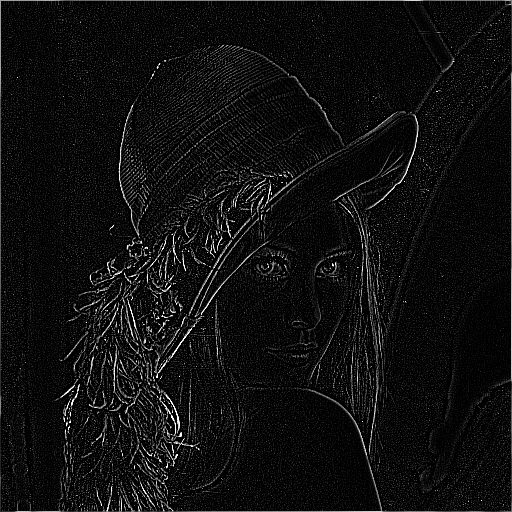

In [2]:
from PIL import Image,ImageFilter
import urllib.request
import skimage.io

# save the image from the url
urllib.request.urlretrieve('https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png', 
                           'lenna.png')

# load the image using PIL.Image
img_lenna = Image.open('lenna.png')
# convert the image into gray scale
img_lenna_gray = img_lenna.convert("L")
# detect the edges using the argumented filter
image_edge = img_lenna_gray.filter(ImageFilter.FIND_EDGES)
display(image_edge)

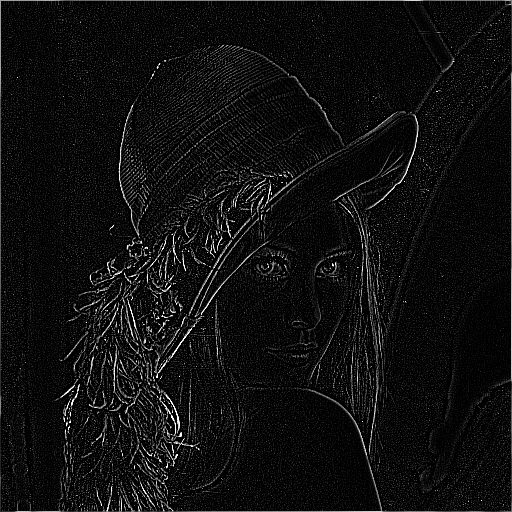

In [7]:
# detect the edges using the Laplacian filter
image_edge = img_lenna_gray.filter(ImageFilter.Kernel((3, 3), (-1, -1, -1, -1, 8,
                                          -1, -1, -1, -1), 1, 0))
display(image_edge)

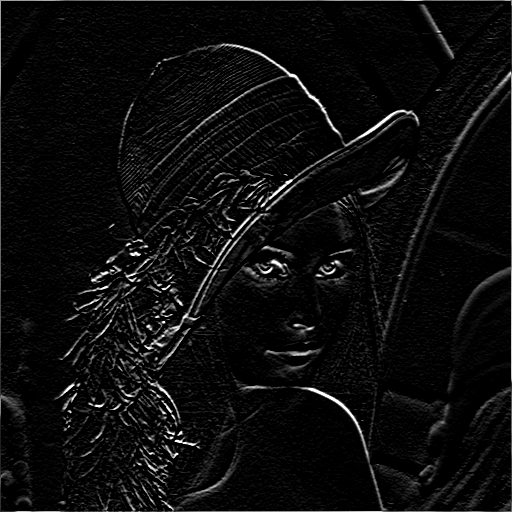

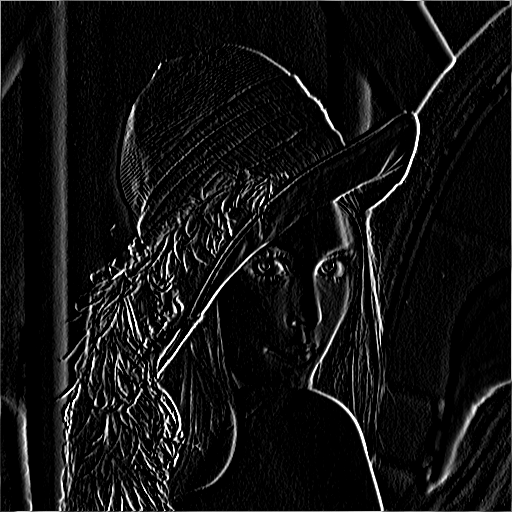

In [ ]:
# detect the edges using the Sobel filters
image_edge_x = img_lenna_gray.filter(ImageFilter.Kernel((3, 3), (1, 2, 1, 0, 0,
                                          0, -1, -2, -1), 1, 0))
display(image_edge_x)
image_edge_y = img_lenna_gray.filter(ImageFilter.Kernel((3, 3), (1, 0, -1, 2, 0,
                                          -2, 1, 0, -1), 1, 0))
display(image_edge_y)

Filters is a useful tool not only for Edge Detection. Let's try Noise Reduction.

# **2. Noise Detection**

But we need to add some noise to the image first. To this end, we use the *random_noise* function (declared in *skimage.util*).

<class 'numpy.ndarray'>
float64


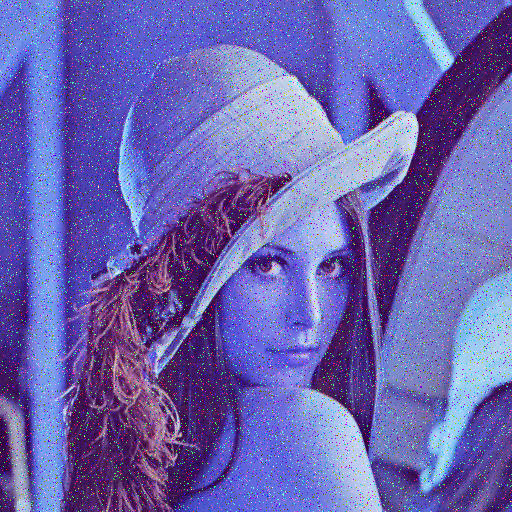

In [12]:
from skimage.util import random_noise
import cv2
import numpy as np

# load the image
img_lenna = cv2.imread('lenna.png')
# Add salt-and-pepper noise
lenna_noise_array = random_noise(img_lenna, mode='s&p',amount=0.05)
print(type(lenna_noise_array))
print((lenna_noise_array.dtype))
# we have to convert the array into uint8 before composing the image
lenna_noise_array = np.array(255*lenna_noise_array, dtype = 'uint8')
lenna_noise_img=Image.fromarray(lenna_noise_array)
display(lenna_noise_img)

Mean filter is one of the simpliest spatial filters.

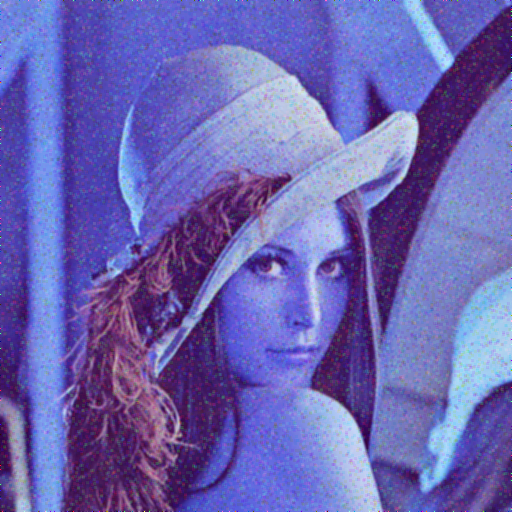

In [ ]:
image_denoise = lenna_noise_img.filter(ImageFilter.Kernel((3, 3), (1/9, 1/9, 1/9, 1/9, 1/9,
                                          1/9, 1/9, 1/9, 1/9), 1, 0))
display(image_denoise)

The Mean filters average out the noise. However, the normal pixels are blured at the same time.

Instead of using the average-out, the Median filters reduce the noise by “replacing” the central pixel by the median of pixels in the neighborhood. The assumption is that noise appear as the “outliers” on which the median works better than the mean.

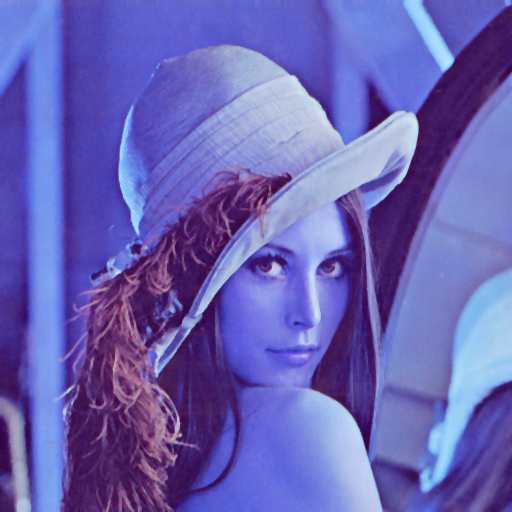

In [ ]:
image_denoise = lenna_noise_img.filter(ImageFilter.MedianFilter)
display(image_denoise)

Median filters seem worked better than Mean filters for salt-and-pepper noise. However, it doesn’t mean it’s a better choice in a general sense. The performance of filters are dependent on the type of noise. 


# **3. Morphological Operations**

Another set of tools, which is similar to Filters, is Morphological Operations.

Structing elements can be considered as filters with which a different way of filtering (i.e., Morphological Operations) is defined (rather than using the weighted averages).

In addition, it is usually applied to the binary images, on which it’s easier to determine the fitness of a structing element to image positions.

Let's learn this through a new example of "Find the Coronavirus". The goal is to locate and count the coronavirus in an image as shown below.

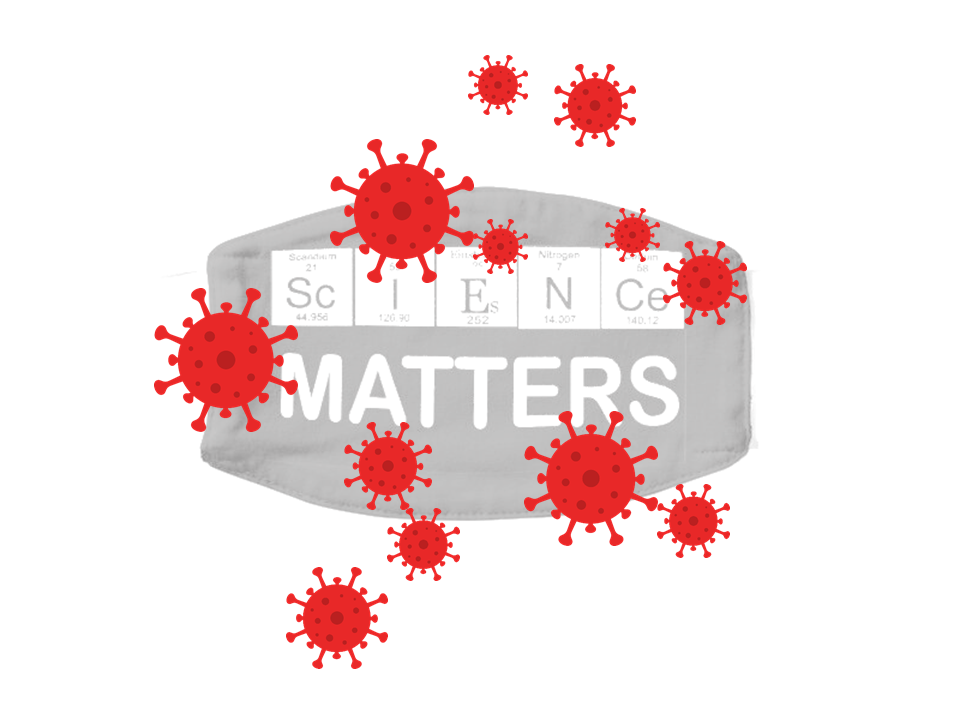

(720, 960)


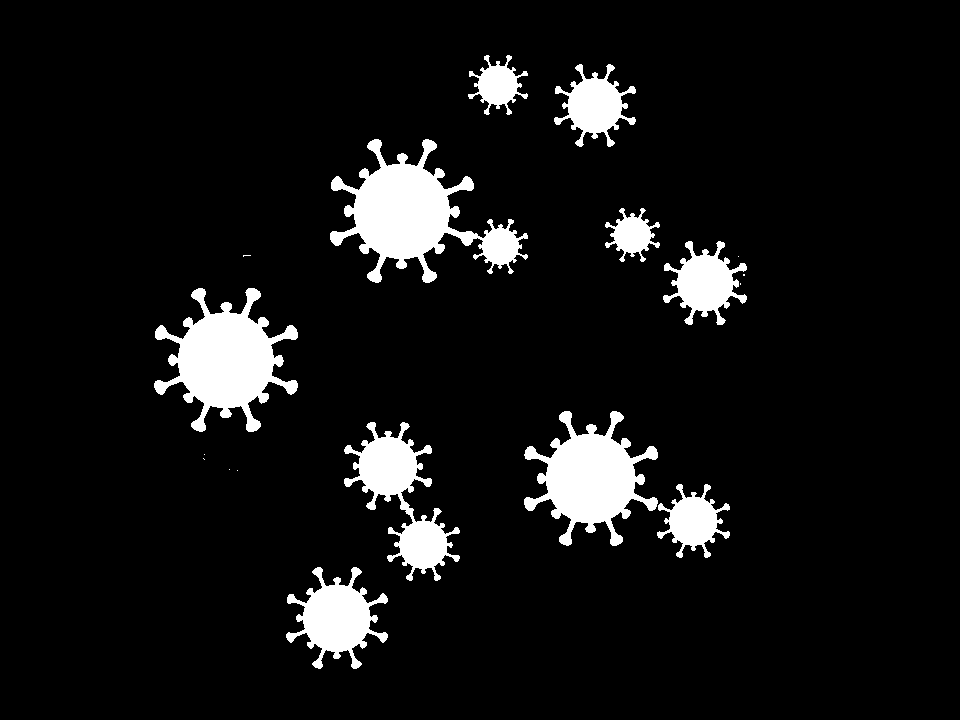

In [14]:
import cv2

# load the image containing coronavirus
np_virus=cv2.imread("T1-coronvirus-mask.png")
#cv2 images are stored in BGR order, we need to convert the order before disaply
display(Image.fromarray(cv2.cvtColor(np_virus, cv2.COLOR_BGR2RGB))) 
# convert to grey image
img_vir_grey = cv2.cvtColor(np_virus, cv2.COLOR_BGR2GRAY)
# get the binary image after thresholding
ret,img_th = cv2.threshold(img_vir_grey,160,255,cv2.THRESH_BINARY)
print(img_th.shape)
bw_img=Image.fromarray(255-img_th)
display(bw_img)

Looks good! But there are noise and connected components, which distract the computers from counting the virus precisely.

Erosion excludes the positions that the Structing Element (SE) dose not fits. We can design a SE that fits into the bodies of virus but not the noise and connections.

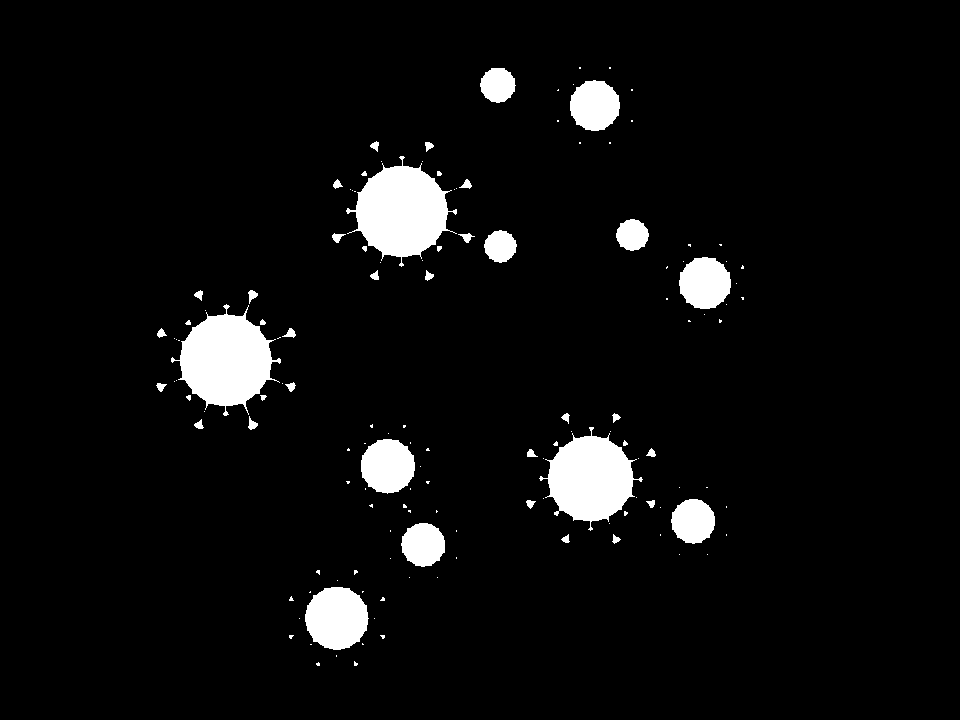

In [21]:
import numpy as np 
#define a 5x5 SE
SE = np.ones((5,5),np.uint8)
img_erosion = cv2.erode(255-img_th,SE,iterations = 1)
bw_img=Image.fromarray(img_erosion)
display(bw_img)

The 5x5 SE does exclude the noise and break the connected components, but isolates the Spike Glycoproteins from the body at the same time. 

After several times of trail-and-error, I found the 12x12 is a good choice for the SE.

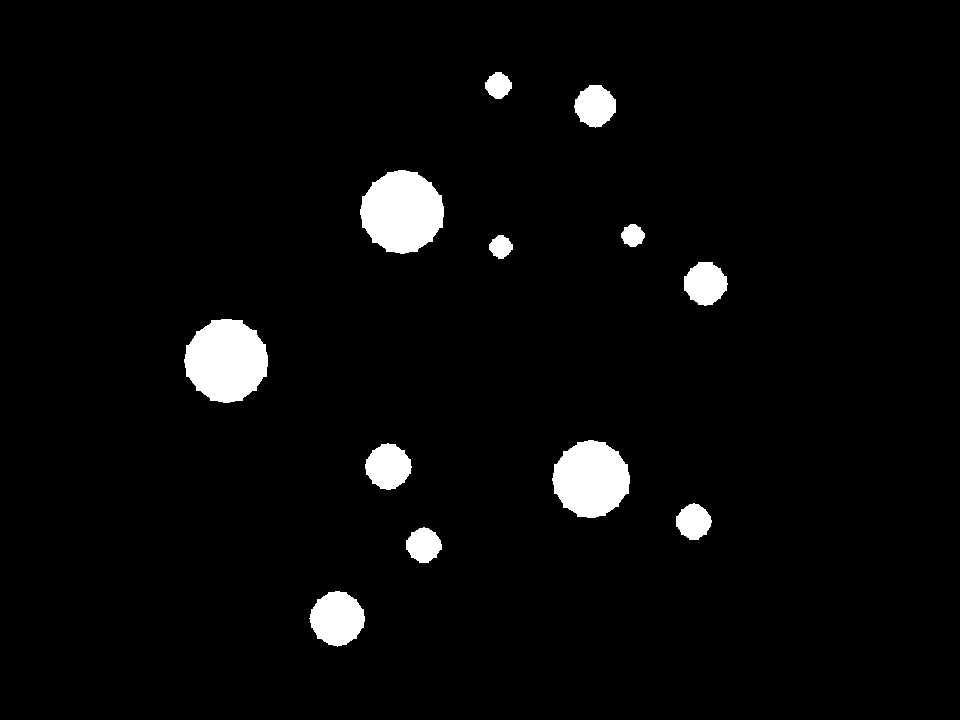

In [22]:
SE = np.ones((12,12),np.uint8)
img_erosion = cv2.erode(255-img_th,SE,iterations = 1)
bw_img=Image.fromarray(img_erosion)
display(bw_img)

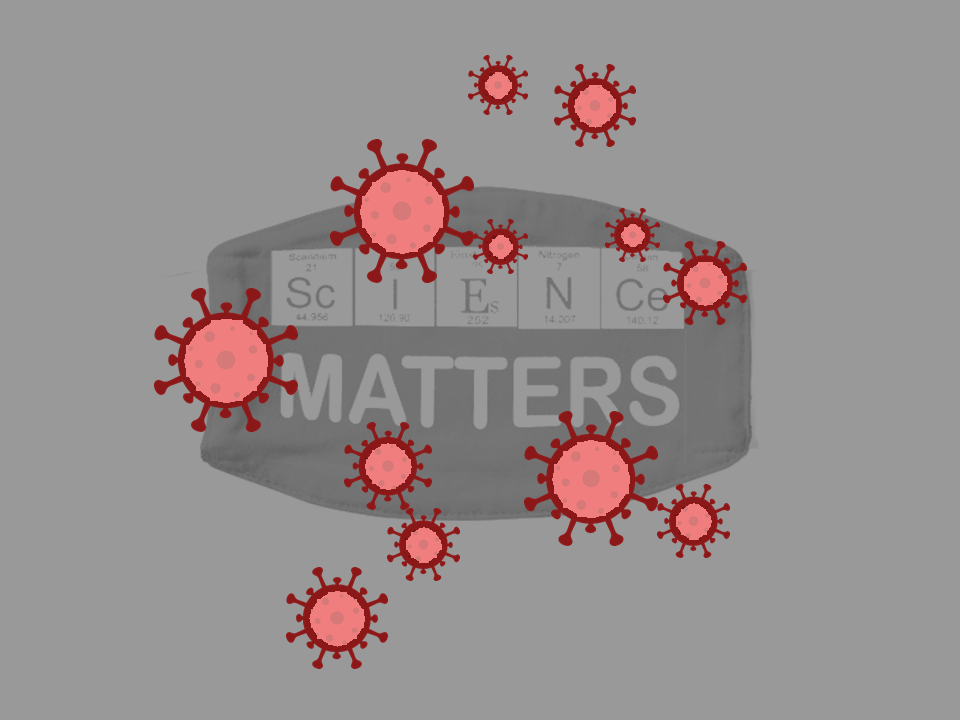

In [23]:
# let's merage it back the orginal image and see the result of localization
np_merge=cv2.merge((img_erosion,img_erosion,img_erosion))*0.4+np_virus*0.6
display(Image.fromarray(cv2.cvtColor(np_merge.astype(np.uint8), cv2.COLOR_BGR2RGB))) 

The white dots hit the viruses well, which meams we can count the viruses by the number of dots.

This can be done using the ***skimage.measure.label*** and ***skimage.measure.regionprops***.

F:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


12


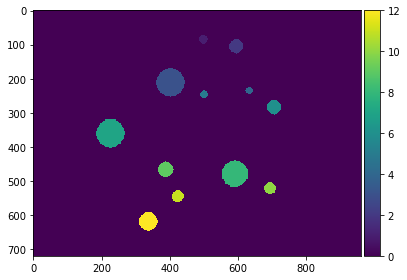

In [24]:
from skimage.measure import label,regionprops
from skimage import io
np_labeled=label(img_erosion)
io.imshow(np_labeled)
regions = regionprops(np_labeled)
print(len(regions))

Studies show that the bigger a virus is, the more infectious it is. (I made it up. It’s not necessarily true.) Can you measure how infectious each of the virus is?

We can measure the area of each virus. In that case, we need to build a mask for each virus first. This can be done using **Dilation**.

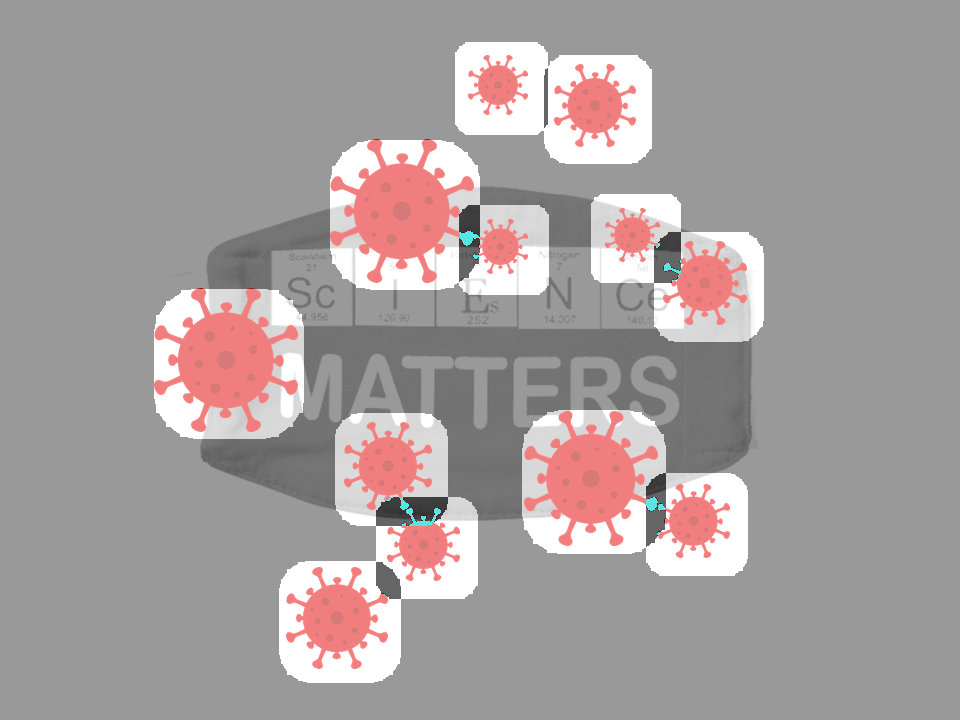

In [25]:
np_regions=[]
np_masks=[]
merged_mask=np.zeros(np_labeled.shape)
for index in range(1, np_labeled.max()+1):
    np_regions.append((((np_labeled==index)+0)*255).astype(np.uint8))
    np_dilation = cv2.dilate(np_regions[-1],SE,iterations = 6)
    np_masks.append(np_dilation)
    merged_mask=merged_mask+np_dilation
    #display(Image.fromarray(np_dilation))

np_merge=cv2.merge((merged_mask,merged_mask,merged_mask))*0.4+np_virus*0.6
display(Image.fromarray(cv2.cvtColor(np_merge.astype(np.uint8), cv2.COLOR_BGR2RGB)))

The masks cover the viruses well. Now we can use the masks to separate the viruses from each other. This can be done by calculating the AND of a mask and the original binary image.

Area of virus 1:	1660
Area of virus 2:	3165
Area of virus 3:	9904
Area of virus 4:	1546
Area of virus 5:	1636
Area of virus 6:	3453
Area of virus 7:	9912
Area of virus 8:	8716
Area of virus 9:	4038
Area of virus 10:	2666
Area of virus 11:	2607
Area of virus 12:	4877


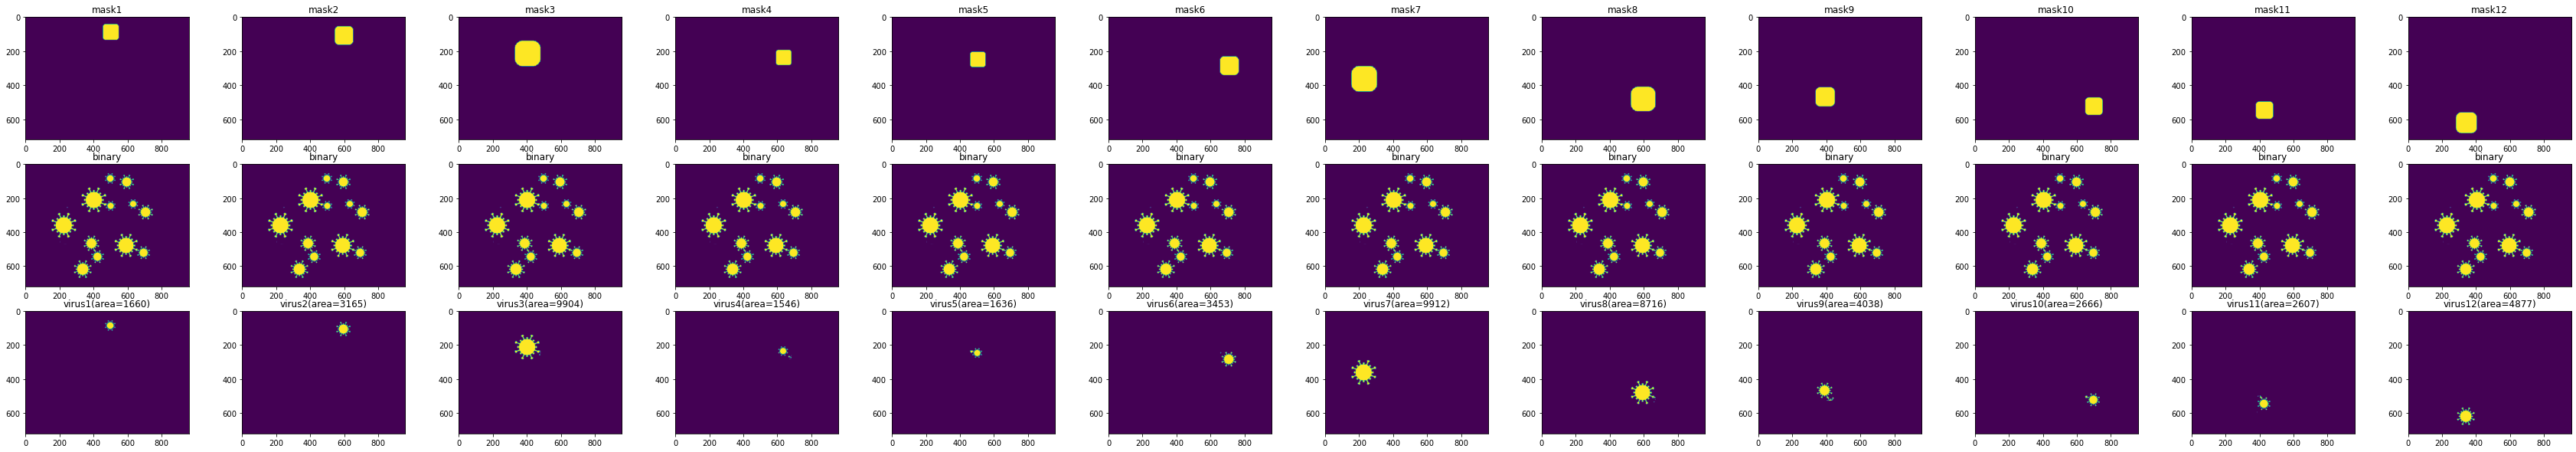

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(60, 10))
binary_np=255-img_th
idx=1
plts=[]
for mask in np_masks:
    binary_virus=((mask==255)*(binary_np==255))
    area=np.sum(binary_virus)
    #display(Image.fromarray(cv2.cvtColor((binary_virus*255).astype(np.uint8), cv2.COLOR_BGR2RGB)))
    plts.append(fig.add_subplot(3, 12, idx))
    plts[-1].set_title('mask'+str(idx))
    plt.imshow(mask)
    plts.append(fig.add_subplot(3, 12, idx+12))
    plts[-1].set_title('binary')
    plt.imshow(binary_np)
    plts.append(fig.add_subplot(3, 12, idx+24))
    plts[-1].set_title('virus'+str(idx)+'(area='+str(area)+')')
    plt.imshow(binary_virus)
    print('Area of virus '+str(idx)+':\t'+str(area))
    idx=idx+1

Not perfect, but OK. Is there a better way to separate the viruses?